In [1]:
import torch
from math import floor
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

from AnalyzeTools.models import autoregressive_integrated_moving_average, linear_regression, support_vector_regression, random_forest, gradient_boosting
from AnalyzeTools.prepare import data_split, model_eval, pathForSavingModels
from AnalyzeTools.preprocess import preprocessData
from AnalyzeTools.superModels import DEEPAR, TFT, RNN

c:\Users\zyf13\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 123


# 경략가격집계 - 소,돼지.csv

In [2]:
''' Read data '''
params_path = '../Parameters'
raw_file_name = '경략가격집계 - 소,돼지'
product = "pork"
product_attribute = "경락가격"

_output = 'MAX_COST_AMT' # MIN_COST_AMT
default_exclude_cols = ['JUDGE_GUBN', 'JUDGE_BREED', 'JUDGE_SEX', 'SABLE_GUBN', 'ABATT_CODE']

df = pd.read_csv('../Data/beef/경략가격집계 - 소,돼지.csv', encoding = 'euc_kr', engine ='python').query("JUDGE_KIND == 2")

In [3]:
df = df.drop(default_exclude_cols, axis=1)
df = df.groupby(['STD_DATE']).mean().reset_index()
df['STD_DATE'] = df['STD_DATE'].apply(lambda x: "20" + "-".join(x.split("/")))

df, _input = preprocessData(df, 'STD_DATE', _output)


Feature scores:
   {'CNT': 10.830940879245123, 'MIN_COST_AMT': 12225.92215065452, 'SUM_COST_AMT': 453.80333127638863, 'SUM_WEIGHT': 22.771022320410545, 'DEFECT_CNT': 10.847147039897516, 'DEFECT_MIN_COST_AMT': 12224.429538051429, 'DEFECT_MAX_COST_AMT': 68115742426.72451, 'DEFECT_SUM_COST_AMT': 453.74541708319583, 'DEFECT_SUM_WEIGHT': 22.79391001099421}

TOP K features:
   ['MIN_COST_AMT', 'SUM_COST_AMT', 'DEFECT_MIN_COST_AMT', 'DEFECT_MAX_COST_AMT']


In [4]:
# prepare dataset for ML or DL
ml_split_params = {'Model': 'ML', 'Future': 1}
X_train, X_test, y_train, y_test = data_split(df, input_cols=_input, output=_output, train_size=0.8, **ml_split_params)

''' Input data into models and Evaluate model results '''
ml_searchCV_params = {
    'base_dir': params_path,
    'product': product,
    'attribute': product_attribute,
    'raw': raw_file_name,
    'save': True
}
stdout = True
vis = False

print("\nARIMA")
arima = autoregressive_integrated_moving_average(y_train)
model_eval(y_test, arima.predict(n_periods=len(y_test), return_conf_int=False, aplha=0.05), stdout=stdout, vis=vis)

print("\nLinear Regression")
lr, _ = linear_regression(X_train, y_train)
model_eval(y_test, lr.predict(X_test), stdout=stdout, vis=vis)

print("\nSupport Vector Regression")
svr, _ = support_vector_regression(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, svr.predict(X_test), stdout=stdout, vis=vis)

print("\nRandom Forest")
rf, _ = random_forest(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, rf.predict(X_test), stdout=stdout, vis=vis)

print("\nGradient Boosting")
gb, _ = gradient_boosting(X_train, y_train, search=True, **ml_searchCV_params)
model_eval(y_test, gb.predict(X_test), stdout=stdout, vis=vis)

X_train: (2037, 3) y_train: (2037,) X_test: (510, 3) y_test: (510,)

ARIMA
MAPE: 0.1267953273530041 R square: 0.16777411797042452

Linear Regression
MAPE: 0.04591060412251238 R square: 0.7887015528604947

Support Vector Regression
MAPE: 0.130217795000294 R square: -0.0320495518475894

Random Forest
MAPE: 0.053333664574350924 R square: 0.7333635877902198

Gradient Boosting
MAPE: 0.0562676753142024 R square: 0.6889575041717717


In [5]:
data = df.copy()

data['time_idx'] = range(len(data))
data['group'] = product

training_cutoff = floor(len(data) * 0.8)

max_prediction_length = 1
max_encoder_length = 30 # 7, 14, 30, 60, 120
batch_size = 64

group = ['group']
time_varying_known_categoricals = ['month', 'week']
time_varying_unknown_categoricals = []
time_varying_known_reals = ['time_idx']
time_varying_unknown_reals = _input + [_output]

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



LSTM


Missing logger folder: d:\Agriculture prediction\Notebooks\Models\pork\경락가격\경략가격집계 - 소,돼지\LSTM\lightning_logs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAPE           | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 867   
3 | rnn              | LSTM           | 78.3 K
4 | output_projector | Linear         | 129   
----------------------------------------------------
79.3 K    Trainable params
0         Non-trainable params
79.3 K    Total params
0.317     Total estimated model params size (MB)


Epoch 30: 100%|██████████| 40/40 [00:04<00:00,  9.64it/s, loss=0.0326, v_num=0, train_loss_step=0.0292, val_loss=0.0396, train_loss_epoch=0.0328]
MAPE: 0.039557941257953644 R square: 0.8654227409182393


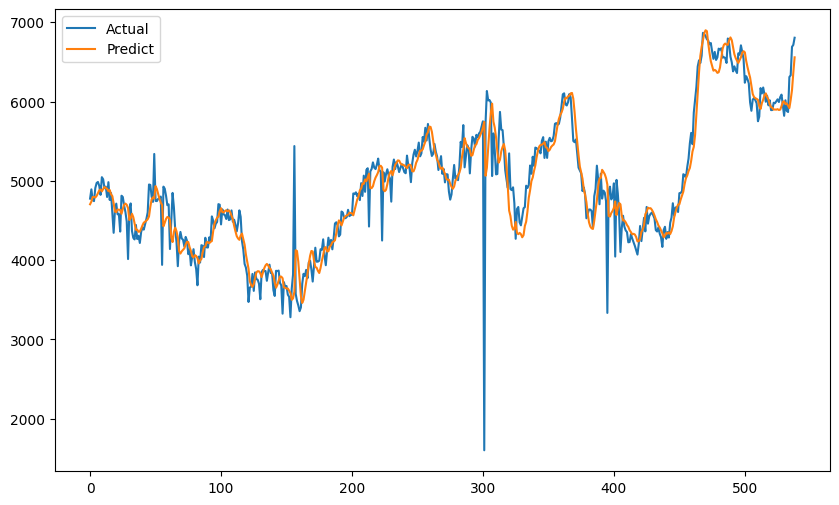

In [6]:
print("\nLSTM")
lstm, val_dataloader = RNN(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'LSTM'),
    'LSTM'
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = lstm.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)


GRU


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Agriculture prediction\Notebooks\Models\pork\경락가격\경략가격집계 - 소,돼지\GRU\lightning_logs

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAPE           | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 867   
3 | rnn              | GRU            | 58.8 K
4 | output_projector | Linear         | 129   
----------------------------------------------------
59.7 K    Trainable params
0         Non-trainable params
59.7 K    Total params
0.239     Total estimated model params size (MB)


Epoch 41: 100%|██████████| 40/40 [00:03<00:00, 10.50it/s, loss=0.0309, v_num=0, train_loss_step=0.0278, val_loss=0.0377, train_loss_epoch=0.0308]
MAPE: 0.037712838500738144 R square: 0.8682143887127423


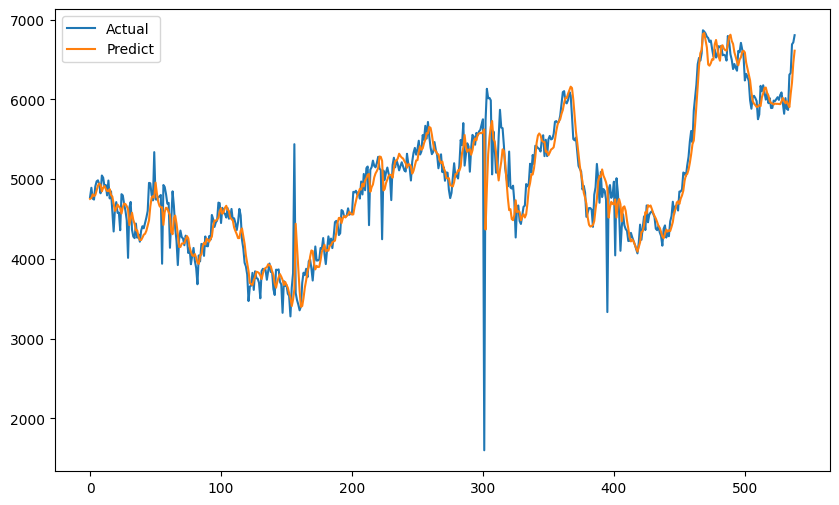

In [7]:
print("\nGRU")
gru, val_dataloader = RNN(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'GRU'),
    'GRU'
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = gru.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)


TFT


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Agriculture prediction\Notebooks\Models\pork\경락가격\경략가격집계 - 소,돼지\TFT\lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAPE                            | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 867   
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 0     
5  | encoder_variable_selection         | VariableSelectionNetwork        | 14.4 K
6  | decoder_variable_selection         | VariableSelectionNetwork        

Epoch 11: 100%|██████████| 40/40 [00:07<00:00,  5.00it/s, loss=0.046, v_num=0, train_loss_step=0.0412, val_loss=0.0593, train_loss_epoch=0.0461]
MAPE: 0.059338122606277466 R square: 0.7215310640942058


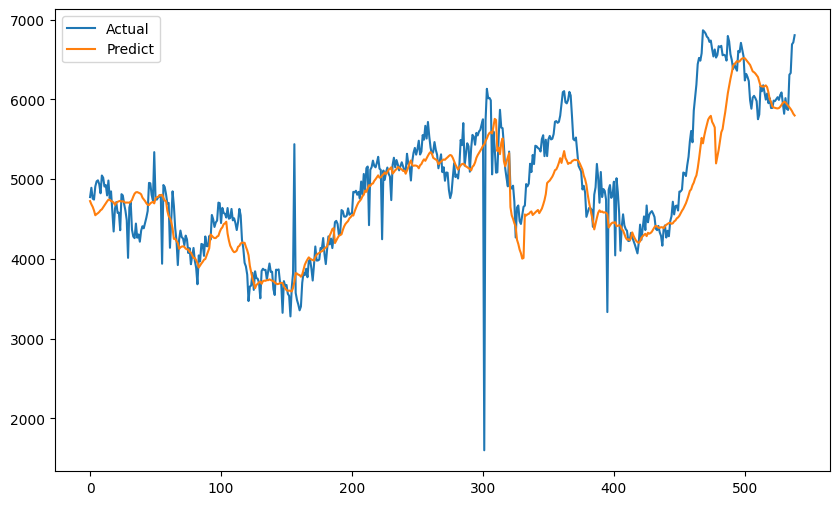

In [8]:
print("\nTFT")
tft, val_dataloader = TFT(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_unknown_categoricals,
    time_varying_known_categoricals,
    time_varying_known_reals,
    time_varying_unknown_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'TFT'),
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: d:\Agriculture prediction\Notebooks\Models\pork\경락가격\경략가격집계 - 소,돼지\DEEPAR\lightning_logs

  | Name                   | Type                   | Params
------------------------------------------------------------------
0 | loss                   | NormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList             | 0     
2 | embeddings             | MultiEmbedding         | 867   
3 | rnn                    | LSTM                   | 211 K 
4 | distribution_projector | Linear                 | 258   
------------------------------------------------------------------
212 K     Trainable params
0         Non-trainable params
212 K     Total params
0.850     Total estimated model params size (MB)



DeepAR
Epoch 8: 100%|██████████| 40/40 [00:06<00:00,  6.36it/s, loss=6.94, v_num=0, train_loss_step=7.070, val_loss=8.090, train_loss_epoch=6.970]
MAPE: 0.05982740595936775 R square: 0.7277677379909697


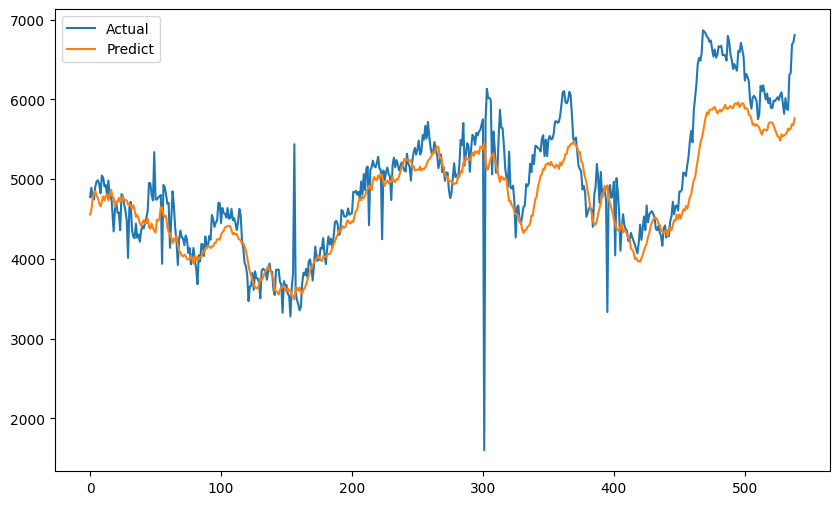

In [9]:
print("\nDeepAR")
deep_ar, val_dataloader = DEEPAR(
    data,
    training_cutoff,
    _output,
    group,
    max_encoder_length,
    max_prediction_length,
    time_varying_known_categoricals,
    time_varying_unknown_categoricals,
    time_varying_known_reals,
    batch_size,
    pathForSavingModels(product, product_attribute, raw_file_name, 'DEEPAR'),
)

actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = deep_ar.predict(val_dataloader)

model_eval(actuals, predictions, stdout=True, vis=True)